# Darks Testing for QHY600M Camera

## Importing Dependencies

Strict requirements are numpy, fits, and matplotlib. <br/>
Additional helpful tools are bit_tools for analysis and plotly for interactive and aesthetic graphs (at the end). Comment/uncomment as desired.

In [2]:
import numpy as np, os
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import bit_tools as bit
import chart_studio.plotly as py # pip install chart_studio
import plotly.graph_objects as go # pip install plotly

## Data Segmentation and Generation

### Import and Segregated List Creation

This code block creates a list of all bias images, appends the path to them to have a list of paths to the bias images, and segregates them by creating three different lists of image paths, corresponding to exposure times of 40us, 100us, and 1ms. To aid in segregation of images and image paths, each image file name has the following structure, with the $\textrm{x}$s denoting values that would be custom set:
<br/>
<br/>
$$ \textrm{Filename =  qhyImg_}\underbrace{\textrm{16xxxxxxx_}}_\textrm{Unix Time}\overbrace{\textrm{exp_xxxus_}}^\textrm{Exposure Time in us}\underbrace{\textrm{gain_xxx_}}_\textrm{Gain Setting}\overbrace{\textrm{offset_xxx_}}^\textrm{Offset Setting}\underbrace{\textrm{xx_}}_\textrm{File Number}\overbrace{\textrm{tempxx}}^\textrm{Temperature}\textrm{.fits}$$
<br/>
<br/>
Images are available on Bee in ~/data2/emaad/qhyTests/biasTest

In [3]:
darksFolder = '/home/emaad/Documents/GitHub/qhyccd/SingleFrameMode/newDarks/' # Folder with images, change as required
biasFolder = '/home/emaad/Documents/GitHub/qhyccd/SingleFrameMode/newBias/'
allImages = os.listdir(darksFolder) # List of all images within folder
allBias = os.listdir(biasFolder)

for i in range(len(allImages)):
    allImages[i] = darksFolder + allImages[i] # Append full path to have a list of paths to all images
    
for i in range(len(allBias)):
    allBias[i] = biasFolder + allBias[i]

# Segregating image paths into lists corresponding to different exposure times
masterExp1 = [image for image in allImages if 'exp_1000000us' in image]
masterExp10 = [image for image in allImages if 'exp_10000000us' in image]
masterExp30 = [image for image in allImages if 'exp_30000000us' in image]
masterExp100 = [image for image in allImages if 'exp_100000000us' in image]
masterExp300 = [image for image in allImages if 'exp_300000000us' in image]

# List of all of them
masterExposures = [masterExp1, masterExp10, masterExp30, masterExp100, masterExp300]

#Segregating image paths into lists corresponding to different temperatures
masterTempNeg5 = [image for image in allImages if 'temp-5' in image]
masterTempNeg4 = [image for image in allImages if 'temp-4' in image]
masterTempNeg3 = [image for image in allImages if 'temp-3' in image]
masterTempNeg2 = [image for image in allImages if 'temp-2' in image]
masterTempNeg1 = [image for image in allImages if 'temp-1' in image]
masterTemp0 = [image for image in allImages if 'temp0' in image]
masterTemp1 = [image for image in allImages if 'temp1' in image]
masterTemp2 = [image for image in allImages if 'temp2' in image]
masterTemp3 = [image for image in allImages if 'temp3' in image]

# List of all of them
masterTemperatures = [masterTempNeg5, masterTempNeg4, masterTempNeg3, masterTempNeg2, masterTempNeg1, masterTemp0, masterTemp1, masterTemp2, masterTemp3, masterTemp4, masterTemp5]

NameError: name 'masterTemp4' is not defined

In [7]:
# All gain setting values
gains = [56]

# All exposure times
exposures = [1, 10, 30, 100, 300]

# All temperatures
temperatures = [-6, -5, -4, -3, -2, -1, 0, 1, 2, 3]

# System gain values corresponding to the gain setting values above
systemGain = np.array([0.330])

# Readnoise for readmode 1 as calculated by QHYCCD
qhyReadNoise = np.array([1.683])

## Dark Current Analysis (all pixels)

In [48]:
expMeans = []
expMedians = []

for mexp in masterExposures:
    
    tempMeans = []
    tempMedians = []
    
    for t in temperatures:
        checkText = 'temp' + str(t)
        
        slicedByTemp = [image for image in mexp if checkText in image]
        relatedBias = [image for image in allBias if checkText in image]
        
        meanpixval = []
        medianpixval = []
        
        for slt in slicedByTemp:
            bsubtract = np.array(fits.getdata(slt),dtype=np.int32) - np.array(fits.getdata(relatedBias[0]),dtype=np.int32)
            #bsubtract = fits.getdata(slt)

            meanpixval.append(np.mean(bsubtract))
            medianpixval.append(np.median(bsubtract))
            
        tempMeans.append(np.mean(meanpixval))
        tempMedians.append(np.mean(medianpixval))
    
    expMeans.append(tempMeans)
    expMedians.append(tempMedians)
        

In [51]:
fig = go.Figure()
excount = 0

for mxp in expMeans:
    nameText = 'Exposure: ' + str(exposures[excount]) + 'sec'
    fig.add_trace(go.Scatter(x = temperatures, y = mxp, mode='lines+markers', name = nameText))
    
    excount += 1

fig.update_layout(title = 'Temperature vs Mean Pixel Value', xaxis_title = 'Temperature (C)', yaxis_title = 'Mean Pixel Value')
fig.show()

In [62]:
fig = go.Figure()
excount = 0

megaslope = []

for txp in temperatures:
    nameText = 'Temperature: ' + str(txp) + 'C'
    
    whatwewant = []
    for mxp in expMeans:
        whatwewant.append(mxp[excount])
        
    m, b = np.polyfit(exposures, whatwewant, 1)
        
    slope = m*.330
    
    megaslope.append(slope)
        
    nameText = 'Temperature: ' + str(txp) + 'C, Slope ='  + str(slope)
    
    fig.add_trace(go.Scatter(x = exposures, y = whatwewant, mode='lines+markers', name = nameText))
    
    excount += 1

fig.update_layout(title = 'Exposure Time vs Mean Pixel Value', xaxis_title = 'Exposure Time (s)', yaxis_title = 'Mean Pixel Value')
fig.show()

In [63]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = temperatures, y = megaslope, mode='lines+markers'))
    
fig.update_layout(title = 'Temperature vs Dark Current', xaxis_title = 'Temperature (C)', yaxis_title = 'Dark Current (e-/p/s)')
fig.show()

## Dark Current Analysis (extreme pixels cut out)

In [ ]:
expMeans = []
expMedians = []

for mexp in masterExposures:
    
    tempMeans = []
    tempMedians = []
    
    for t in temperatures:
        checkText = 'temp' + str(t)
        
        slicedByTemp = [image for image in mexp if checkText in image]
        relatedBias = [image for image in allBias if checkText in image]
        
        meanpixval = []
        medianpixval = []
        
        for slt in slicedByTemp:
            bsubtract = np.array(fits.getdata(slt),dtype=np.int32) - np.array(fits.getdata(relatedBias[0]),dtype=np.int32)
             
            oneDImage = np.reshape(bsubtract, 9600*6422)
            meanOfImage = np.mean(oneDImage)
            stdOfImage = np.std(oneDImage)
            
            for i in range(len(oneDImage)):
                if (oneDImage[i] < (meanOfImage - 3*stdOfImage)) or (oneDImage[i] > (meanOfImage + 3*stdOfImage)):
                    np.delete(oneDImage, i)           
            
            meanpixval.append(np.mean(oneDImage))
            medianpixval.append(np.median(oneDImage))
            
        tempMeans.append(np.mean(meanpixval))
        tempMedians.append(np.mean(medianpixval))
    
    expMeans.append(tempMeans)
    expMedians.append(tempMedians)
        

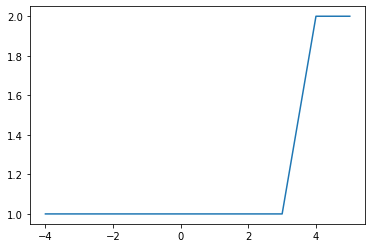

In [21]:
masterExp100 = [image for image in gain56images if 'exp_100000000us' in image]

meanValues = []
medianValues = []

temperaturesno5 = [-4, -3, -2, -1, 0, 1, 2, 3, 4, 5]

for te in temperaturesno5:
    
    meanpval = []
    medianpval = []
    
    checkText = 'temp' + str(te)
        
    slicer = [image for image in masterExp100 if checkText in image]
    biasRelated = [image for image in allBias if checkText in image]
    
    for s in slicer:
        subtracted = np.array(fits.getdata(s), dtype=np.int32) - np.array(fits.getdata(biasRelated[0]),dtype=np.int32)
        
        meanpval.append(np.mean(subtracted))
        medianpval.append(np.median(subtracted))
        
    meanValues.append(np.mean(meanpval))
    medianValues.append(np.mean(medianpval))


plt.plot(temperaturesno5, medianValues)
        

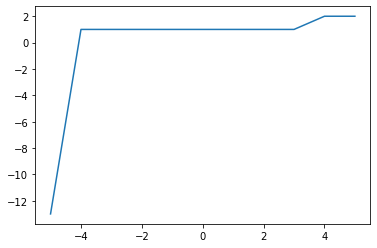

In [19]:
plt.plot(temperatures, medianValues)


In [5]:
for g in gains:
    checkText = 'gain_' + str(g) + '_' # Create string with specific gain setting to check against the image names
    spliced = [image for image in masterExp40 if checkText in image] # Splice out image paths with specific gain setting
    stdvalues = []

    # Take the difference of nine images and append values of the standard deviations in the stdvalues array above
    for i in range(len(spliced) - 1):
        delta = np.array(fits.getdata(spliced[i]),dtype=np.int32) - np.array(fits.getdata(spliced[i+1]),dtype=np.int32)
        stdvalues.append(np.std(delta))

    # Append the mean standard deviation for specific gain setting
    meanvalues40.append(np.mean(stdvalues))

In [6]:
meanval40 = np.array(meanvalues40) # Convert to numpy array for ease of calculations
readNoise40 = (meanval40/np.sqrt(2))*systemGain # Calculate readnoise

Readnoise calculation for exposure time 100us:

In [7]:
for g in gains:
    checkText = 'gain_' + str(g) + '_' # Create string with specific gain setting to check against the image names
    spliced = [image for image in masterExp100 if checkText in image] # Splice out image paths with specific gain setting
    stdvalues = []

    # Take the difference of nine images and append values of the standard deviations in the stdvalues array above
    for i in range(len(spliced) - 1):
        delta = np.array(fits.getdata(spliced[i]),dtype=np.int32) - np.array(fits.getdata(spliced[i+1]),dtype=np.int32)
        stdvalues.append(np.std(delta))

    # Append the mean standard deviation for specific gain setting
    meanvalues100.append(np.mean(stdvalues))

In [8]:
meanval100 = np.array(meanvalues100) # Convert to numpy array for ease of calculations
readNoise100 = (meanval100/np.sqrt(2))*systemGain # Calculate readnoise

Readnoise calculation for exposure time 1ms:

In [9]:
for g in gains:
    checkText = 'gain_' + str(g) + '_' # Create string with specific gain setting to check against the image names
    spliced = [image for image in masterExp1000 if checkText in image] # Splice out image paths with specific gain setting
    stdvalues = []

    # Take the difference of nine images and append values of the standard deviations in the stdvalues array above
    for i in range(len(spliced) - 1):
        delta = np.array(fits.getdata(spliced[i]),dtype=np.int32) - np.array(fits.getdata(spliced[i+1]),dtype=np.int32)
        stdvalues.append(np.std(delta))

    # Append the mean standard deviation for specific gain setting
    meanvalues1000.append(np.mean(stdvalues))

In [10]:
meanval1000 = np.array(meanvalues1000) # Convert to numpy array for ease of calculations
readNoise1000 = (meanval1000/np.sqrt(2))*systemGain # Calculate readnoise

## Data Analysis

Below are two sets of three plots, one set in Matplotlib and the other in Plotly (for better interactivity and aesthetics). In each set, the first plot is the Gain Setting vs Readnoise for exposure times of 40us, 100us, and 1ms, as well as using data from QHYCCD, the second plot is System Gain (<a href="https://www.qhyccd.com/index.php?m=content&c=index&a=show&catid=94&id=55&cut=1" target = "_blank">from QHYCCD's website</a>) vs Readnoise for the same exposures as well as QHYCCD calculated values, and the third plot shows the difference between the values QHYCCD calculated and the values we collected, again for each of the three exposure times.
<br/>
<br/>
<strong> For reference, all data collected above was in Readout Mode 1 (The High Gain Mode). </strong>
<br/>
<br/>
As can be seen, the Gain Setting vs Readnoise data agrees with QHYCCD provided data shown on the <a href="https://www.qhyccd.com/index.php?m=content&c=index&a=show&catid=94&id=55&cut=1" target = "_blank">same graph on QHYCCD's website</a>, with average deviation of -0.1 for exposure times of 100us and 1ms, and -0.14 for exposure time of 40us from the values QHYCCD calculated.

### Matplotlib Plots

#### Gain Setting vs Readnoise

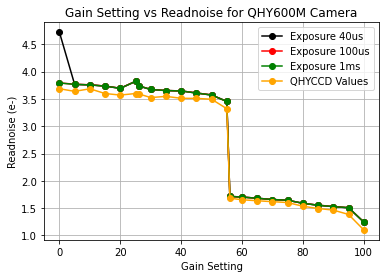

In [11]:
plt.plot(gains, readNoise40, '-o', color= 'black', label = 'Exposure 40us') # Gain vs Readnoise for Exposure 40us
plt.plot(gains, readNoise100, '-o', color = 'red', label = 'Exposure 100us') # Gain vs Readnoise for Exposure 100us
plt.plot(gains, readNoise1000, '-o', color = 'green', label = 'Exposure 1ms') # Gain vs Readnoise for Exposure 1ms
plt.plot(gains, qhyReadNoise, '-o', color = 'orange', label = 'QHYCCD Values') # Gain vs Readnoise for QHYCCD values

plt.title("Gain Setting vs Readnoise for QHY600M Camera")
plt.xlabel("Gain Setting")
plt.ylabel("Readnoise (e-)")
plt.legend()
plt.grid()
plt.show()

#### System Gain vs Readnoise

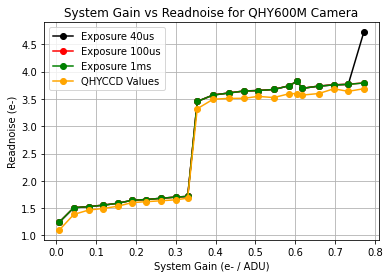

In [12]:
plt.plot(systemGain, readNoise40, '-o', color= 'black', label = 'Exposure 40us') # System Gain vs Readnoise for Exposure 40us
plt.plot(systemGain, readNoise100, '-o', color = 'red', label = 'Exposure 100us') # System Gain vs Readnoise for Exposure 100us
plt.plot(systemGain, readNoise1000, '-o', color = 'green', label = 'Exposure 1ms') # System Gain vs Readnoise for Exposure 1ms
plt.plot(systemGain, qhyReadNoise, '-o', color = 'orange', label = 'QHYCCD Values') # Gain vs Readnoise for QHYCCD values

plt.title("System Gain vs Readnoise for QHY600M Camera")
plt.xlabel("System Gain (e- / ADU)")
plt.ylabel("Readnoise (e-)")
plt.legend()
plt.grid()
plt.show()

#### Difference Between QHYCCD Values and the Values We Collected

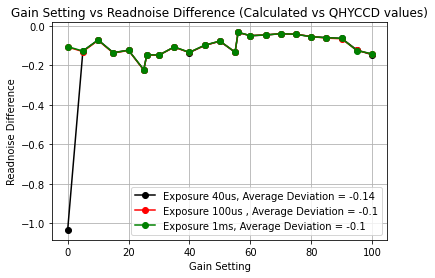

In [13]:
plt.plot(gains, qhyReadNoise - readNoise40, '-o', color= 'black', label = 'Exposure 40us, Average Deviation = ' + str(round(np.mean(qhyReadNoise - readNoise40),2))) # System Gain vs Readnoise for Exposure 40us
plt.plot(gains, qhyReadNoise - readNoise100, '-o', color = 'red', label = 'Exposure 100us , Average Deviation = ' + str(round(np.mean(qhyReadNoise - readNoise100),2))) # System Gain vs Readnoise for Exposure 100us
plt.plot(gains, qhyReadNoise - readNoise1000, '-o', color = 'green', label = 'Exposure 1ms, Average Deviation = ' + str(round(np.mean(qhyReadNoise - readNoise100),2))) # System Gain vs Readnoise for Exposure 1ms

plt.title("Gain Setting vs Readnoise Difference (Calculated vs QHYCCD values)")
plt.xlabel("Gain Setting")
plt.ylabel("Readnoise Difference")
plt.legend()
plt.grid()
plt.show()

### Plotly Plots

These will not run unless you have Plotly installed. Use <strong>pip install plotly</strong> and <strong>pip install chart_studio</strong> to install the dependencies.

#### Gain Setting vs Readnoise

In [14]:
fig = go.Figure()

fig.add_trace(go.Scatter(x = gains, y = readNoise40, mode='lines+markers', name = 'Exposure 40us', marker_color = 'black'))
fig.add_trace(go.Scatter(x = gains, y = readNoise100, mode='lines+markers', name = 'Exposure 100us', marker_color = 'red'))
fig.add_trace(go.Scatter(x = gains, y = readNoise1000, mode='lines+markers', name = 'Exposure 1ms', marker_color = 'green'))
fig.add_trace(go.Scatter(x = gains, y = qhyReadNoise, mode='lines+markers', name = 'QHYCCD Values', marker_color = 'orange'))

fig.update_layout(title = 'Gain Setting vs Readnoise for QHY600M Camera', xaxis_title = 'Gain Setting', yaxis_title = 'Readnoise (e-)')
fig.show()

#### System Gain vs Readnoise

In [15]:
fig2 = go.Figure()

fig2.add_trace(go.Scatter(x = systemGain, y = readNoise40, mode='lines+markers', name = 'Exposure 40us', marker_color = 'black'))
fig2.add_trace(go.Scatter(x = systemGain, y = readNoise100, mode='lines+markers', name = 'Exposure 100us', marker_color = 'red'))
fig2.add_trace(go.Scatter(x = systemGain, y = readNoise1000, mode='lines+markers', name = 'Exposure 1ms', marker_color = 'green'))
fig2.add_trace(go.Scatter(x = systemGain, y = qhyReadNoise, mode='lines+markers', name = 'QHYCCD Values', marker_color = 'orange'))

fig2.update_layout(title = 'System Gain vs Readnoise for QHY600M Camera', xaxis_title = 'System Gain (e- / ADU)', yaxis_title = 'Readnoise (e-)')

fig2.show()

In [16]:
coldLonng = [image for image in masterExp300 if 'temp-5' in image]
coldLong = [image for image in coldLonng if 'gain_56_' in image]

hotLonng = [image for image in masterExp300 if 'temp5' in image]
hotLong = [image for image in hotLonng if 'gain_56' in image]

162.4596055713433 158.0 247.07484377148685


No handles with labels found to put in legend.


Peak = 33006975 FWHM =  13.103000000000009
162.4596055713433 158.0 247.07484377148685


No handles with labels found to put in legend.


Peak = 26653746 FWHM =  13.10420000000002
167.64843091456453 161.0 319.0874992835039


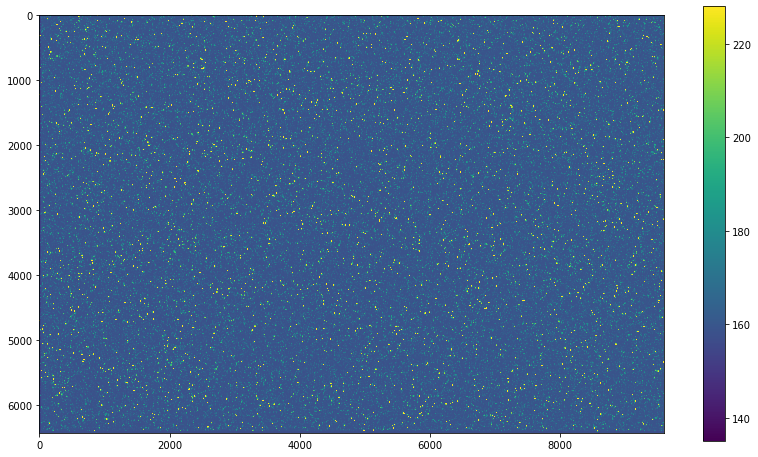

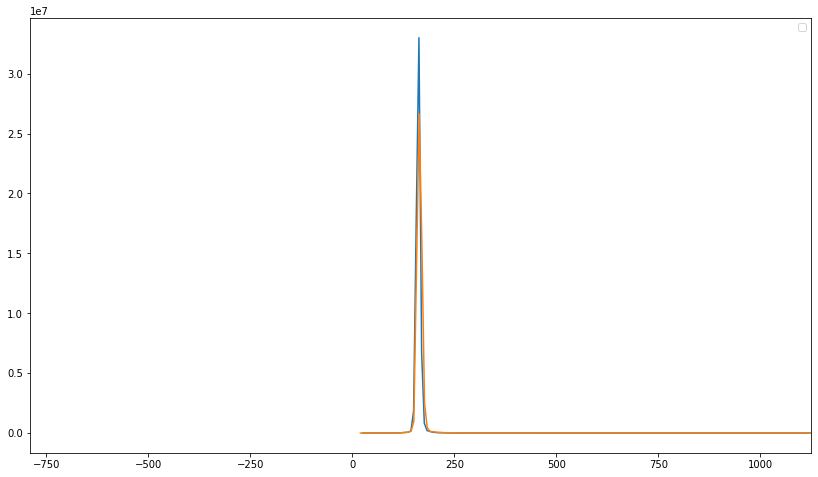

In [25]:
bit.plot.img(fits.getdata(coldLong[0]))
bit.plot.hist(fits.getdata(coldLong[0]))
bit.plot.hist(fits.getdata(hotLong[0]),nfig=False)

167.64843091456453 161.0 319.0874992835039


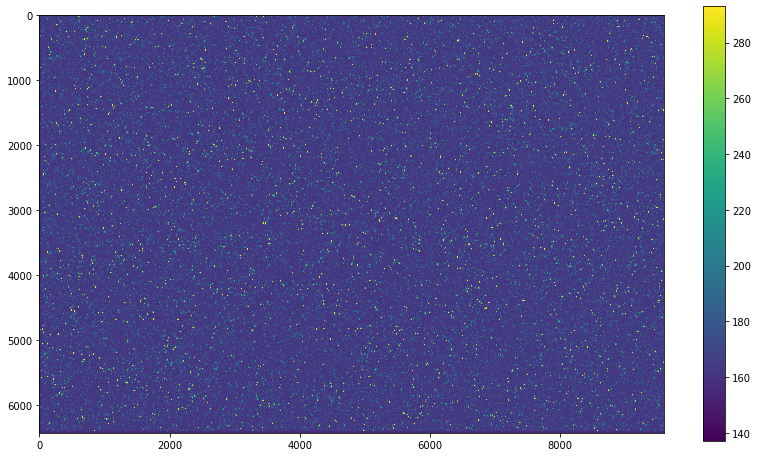

In [19]:
bit.plot.img(fits.getdata(hotLong[0]))

162.4596055713433 158.0 247.07484377148685


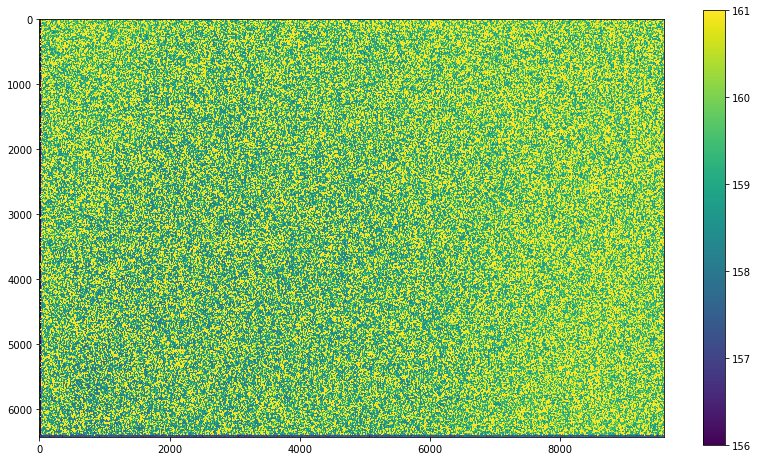

In [23]:
bit.plot.img(fits.getdata(coldLong[0]) , percentile=70)

167.64843091456453 161.0 319.0874992835039


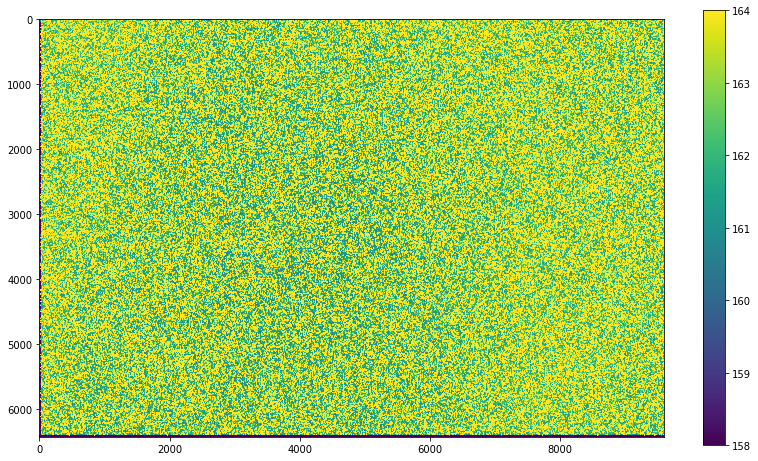

In [22]:
bit.plot.img(fits.getdata(hotLong[0]), percentile=70)